### Prologue
Prepare the notebook for inline plotting<br>
Load required libraries<br>
Create custom functions<br>
Load and preprocess data<br>
Train a random forest using previously optimized/tuned hyper-parameters

In [14]:
from IPython.display import Image
%matplotlib inline
%run rf_analysis_utils.py
%run german_dataprep.py

Utility code in the associated file performs the following steps:
defines function to print pretty confusion matrix: plot_confusion_matrix()
defines a function to get the class code by label: get_class_code()
defines a function to plot a tree inline: tree_to_code()
defines a function to extract all the structural arrays of a tree: get_tree_structure()
defines a function to extract a metrics dictionary from a random forest: explore_forest()
defines a function to pass batches of data to explore_forest(), split by correct/incorrect prediction: batch_analyse_model()
defines function to plot the mean path lengths from an object returned by explore_forest(): plot_mean_path_lengths()
defines a function to map the path of an instance down a tree: tree_path()
defines a function to map the path of an instance down a tree ensemble: forest_path()
defines a function to find the majority predicted class from object returned by forest_path(): major_class_from_forest_paths()
defines a function to conv

The data objects are now saved and given a set of generic names ease of use.

In [15]:
# get the correct directory for saved objects
pickle_dir_store = open("pickle_dir.pickle", "rb")
pickle_dir = pickle.load(pickle_dir_store)
pickle_dir_store.close()

# helper function for pickling files
def pickle_path(filename):
    return(pickle_dir + '\\' + filename)

# load up the training set (required because of running from script into Jup Note)
encoder_store = open(pickle_path('encoder.pickle'), "rb")
encoder = pickle.load(encoder_store)
encoder_store.close()

X_train_enc_store = open(pickle_path('X_train_enc.pickle'), "rb")
X_train_enc = pickle.load(X_train_enc_store)
X_train_enc_store.close()

y_train_store = open(pickle_path('y_train.pickle'), "rb")
y_train = pickle.load(y_train_store)
y_train_store.close()


In [16]:
%run rf_analysis_modelprep.py

Parameter tuning (disabled)
Utility code in the associated file performs the following steps:
set random seed for the random forest
fetch the best parameters from model tuning results

Best OOB Cohen's Kappa during tuning: 0.7571
Best parameters: {'max_depth': 16, 'n_estimators': 1000, 'min_samples_leaf': 1}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model


### Random Forest Performance

Cohen's Kappa on unseen instances: 0.3626
Confusion matrix, without normalization
[[ 39  61]
 [ 14 186]]
Normalized confusion matrix
[[0.39 0.61]
 [0.07 0.93]]


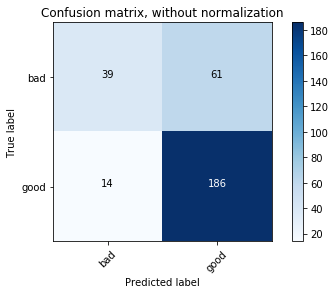

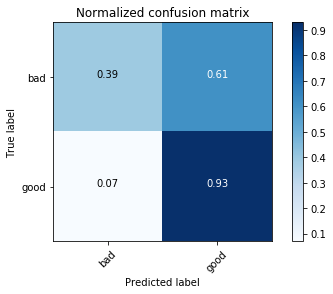

In [17]:
# test the model on unseen data
pred = enc_model.predict(X_test)
print("Cohen's Kappa on unseen instances: " "{:0.4f}".format(metrics.cohen_kappa_score(y_test, pred)))

# view the confusion matrix
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.figure()
# normalized confusion matrix
plot_confusion_matrix(cm
                      , classes=class_names
                      , normalize=True,
                      title='Normalized confusion matrix')

# Part 1. Global Explanations
## Statistical Analysis of a random forest model using data batches
* Inductive Properties are based on the training data
* Transductive Properties are based on the test (held out) data
* In both cases, the whole dataset is passed into the model and statistics are gathered about how frequently the features are visited.

* OOB data (to do)

In [20]:
# First instantiate new survey class with the RF model
f_survey = forest_surveyor(model = rf, features = onehot_features, prediction_model = enc_model)

In [19]:
########################################################################
### This takes a few minutes, so only run when an update is required ###
########################################################################

if True:
    '''
    batch = X_test
    labels = y_test

    correct_preds = enc_model.predict(batch) == labels
    incorrect_preds = enc_model.predict(batch) != labels
    
    if sum(correct_preds) > 0:
        X = batch[correct_preds.values]
        y = labels[correct_preds.values]
        
        f_survey.fit(encoder.transform(X), y, onehot_features)
        f_cor_stats = f_survey.forest_stats(np.unique(y))
        
    if sum(incorrect_preds) > 0:
        X = batch[incorrect_preds.values]
        y = labels[incorrect_preds.values]
        
        f_survey.fit(encoder.transform(X), y, onehot_features)
        f_incor_stats = f_survey.forest_stats(np.unique(y))
    
    tt_correct_stats_store = open(pickle_path('tt_correct_stats.pickle'), "wb")
    pickle.dump(f_cor_stats, tt_correct_stats_store)
    tt_correct_stats_store.close()
    
    tt_incorrect_stats_store = open(pickle_path('tt_incorrect_stats.pickle'), "wb")
    pickle.dump(f_incor_stats, tt_incorrect_stats_store)
    tt_incorrect_stats_store.close()
    '''
    
tt_correct_stats_store = open(pickle_path('tt_correct_stats.pickle'), "rb")
tt_correct_stats = pickle.load(tt_correct_stats_store)
tt_correct_stats_store.close()

tt_incorrect_stats_store = open(pickle_path('tt_incorrect_stats.pickle'), "rb")
tt_incorrect_stats = pickle.load(tt_incorrect_stats_store)
tt_incorrect_stats_store.close()

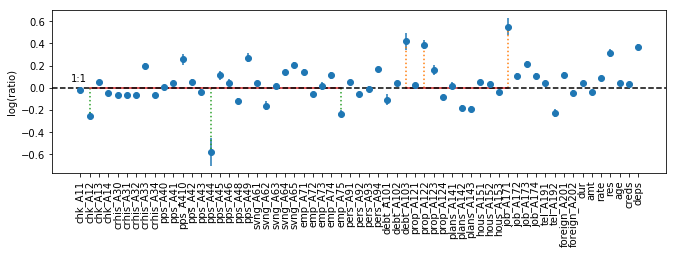

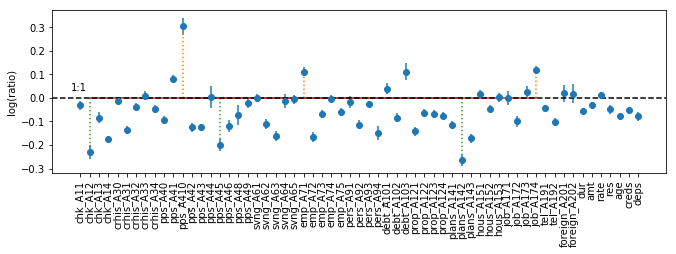

In [7]:
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_child_traversals']
                            , num_err = tt_correct_stats[0]['se_child_traversals']
                            , denom = tt_incorrect_stats[0]['m_child_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_child_traversals']
                            , labels = onehot_features
)
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_lower_traversals']
                            , num_err = tt_correct_stats[0]['se_lower_traversals']
                            , denom = tt_incorrect_stats[0]['m_lower_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_lower_traversals']
                            , labels = onehot_features
)

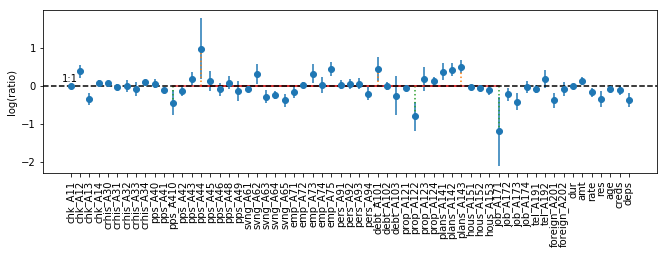

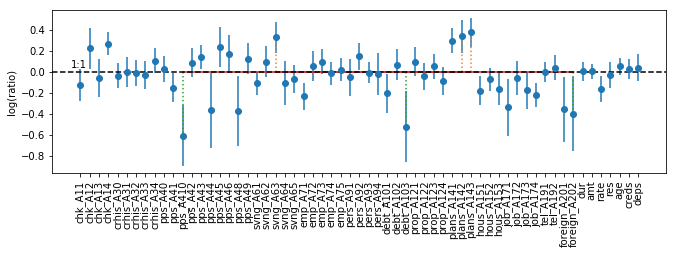

In [8]:
log_ratio = log_ratio_plot(num = tt_correct_stats[1]['m_child_traversals'],
                           denom = tt_correct_stats[0]['m_child_traversals'],
                           num_err = tt_correct_stats[1]['sd_child_traversals'],
                           denom_err = tt_correct_stats[0]['sd_child_traversals'],
                           labels = onehot_features)

log_ratio = log_ratio_plot(num = tt_correct_stats[1]['m_lower_traversals'],
                           denom = tt_correct_stats[0]['m_lower_traversals'],
                           num_err = tt_correct_stats[1]['sd_lower_traversals'],
                           denom_err = tt_correct_stats[0]['sd_lower_traversals'],
                           labels = onehot_features)

# Part 2. Local Explanations
## Analysis of decision paths for individual unseen instances in a random forest model
* Frequent Pattern Mining of decision paths
* Rule Compression of decision paths

In [9]:
first_n = 14 # python is 'up to but not including'

batch = X_test[0:first_n]
labels = y_test[0:first_n]

preds = enc_model.predict(batch)

nfp = forest_path(forest = rf
                , feature_names = onehot_features
                , instances = batch
                , labels = None
                , feature_encoding = encoder
                , by_tree = False)

paths = {}
for instance in range(first_n):
    paths[instance] = get_paths(nfp, instance, by_tree = False, which_trees='majority')

# there is a bug in sklearn causing all the warnings. This should be fixed in next release.
pretty_print_tree_votes(paths, preds, labels)

Instance 0:    True Class = 0 bad    Pred Class = 0 bad    Majority voting trees = 643
Instance 1:    True Class = 0 bad    Pred Class = 1 good    Majority voting trees = 500
Instance 2:    True Class = 1 good    Pred Class = 1 good    Majority voting trees = 681
Instance 3:    True Class = 0 bad    Pred Class = 0 bad    Majority voting trees = 639
Instance 4:    True Class = 1 good    Pred Class = 1 good    Majority voting trees = 735
Instance 5:    True Class = 1 good    Pred Class = 1 good    Majority voting trees = 669
Instance 6:    True Class = 1 good    Pred Class = 1 good    Majority voting trees = 546
Instance 7:    True Class = 1 good    Pred Class = 1 good    Majority voting trees = 558
Instance 8:    True Class = 0 bad    Pred Class = 0 bad    Majority voting trees = 581
Instance 9:    True Class = 1 good    Pred Class = 1 good    Majority voting trees = 741
Instance 10:    True Class = 0 bad    Pred Class = 1 good    Majority voting trees = 839
Instance 11:    True Class =

C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

In [10]:
# profiling a single instance
instance = 1

# Collect useful data for instance
true_class = labels[instance:instance+1].values[0]
pred_probs = enc_model.predict_proba(batch[instance:instance + 1])[0]

print('Test instance id: ' + str(instance))
print('True class: ' + str(true_class))
print('Pedicted Class Probabilities ')
for c, n, p in zip(class_names, range(len(class_names)), pred_probs):
    print(n, c, "{:0.4f}".format(p))

# get the class codes produced by the model and the true class
true_class_code = get_label(class_col, true_class)

class_code_confs = np.argsort(pred_probs)[::-1] # descending order
pred_class_code = get_code(class_col, class_names[class_code_confs[0]])
second_class_code = get_code(class_col, class_names[class_code_confs[1]])

# Display instance row
germ_id = batch[instance:instance + 1].index[0]
german[germ_id:germ_id + 1]

Test instance id: 1
True class: 0
Pedicted Class Probabilities 
0 bad 0.4997
1 good 0.5003


C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,chk,dur,crhis,pps,amt,svng,emp,rate,pers,debt,...,prop,age,plans,hous,creds,job,deps,tel,foreign,rating
203,A11,12,A32,A48,902,A61,A74,4,A94,A101,...,A122,21,A143,A151,1,A173,1,A191,A201,bad


C:\Dev\Study\python\interpret_basics2\rf_analysis_utils.py:933: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(2)
C:\Dev\Study\python\interpret_basics2\rf_analysis_utils.py:937: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(2)


('amt', True, 1777.39) feature first added
('amt', True, 1777.39) feature appears already
('amt', True, 1777.39) feature values appears already
('age', True, 26.81) feature first added
('dur', False, 9.97) feature first added
('dur', True, 15.87) feature appears already
('dur', True, 15.87) feature values with new discontinuity
('res', False, 1.5) feature first added
('rate', False, 2.0) feature first added


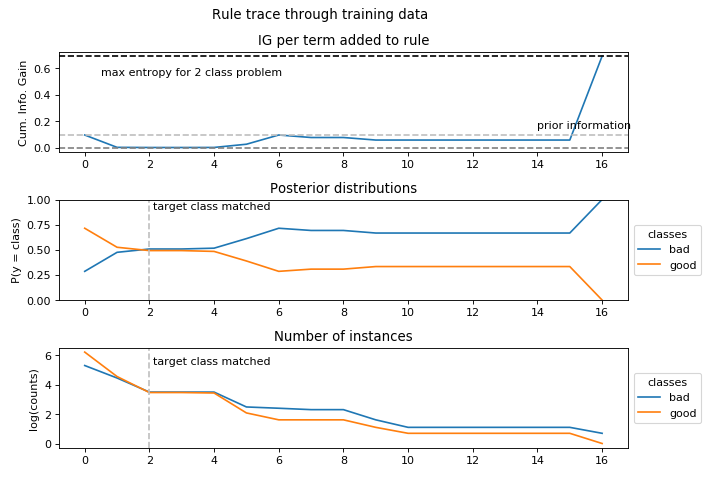

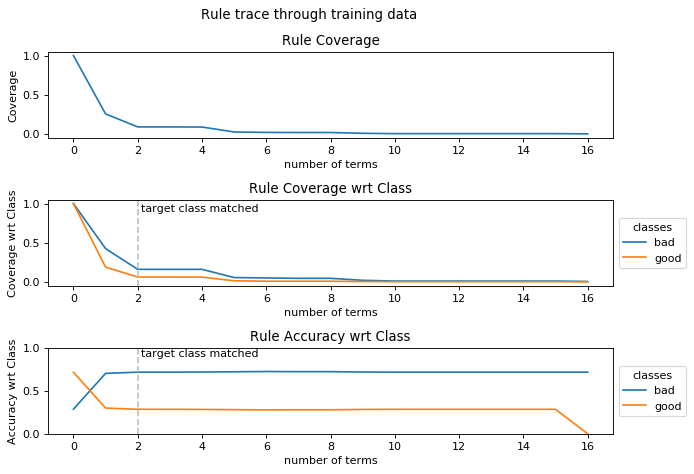

('amt', True, 1773.27) feature first added
('age', True, 26.43) feature first added
('dur', True, 16.58) feature first added
('dur', False, 9.98) feature appears already
('dur', False, 9.98) feature values with new discontinuity


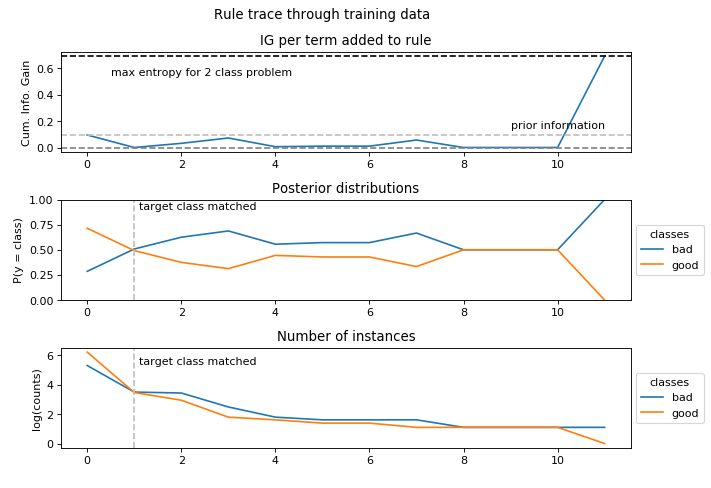

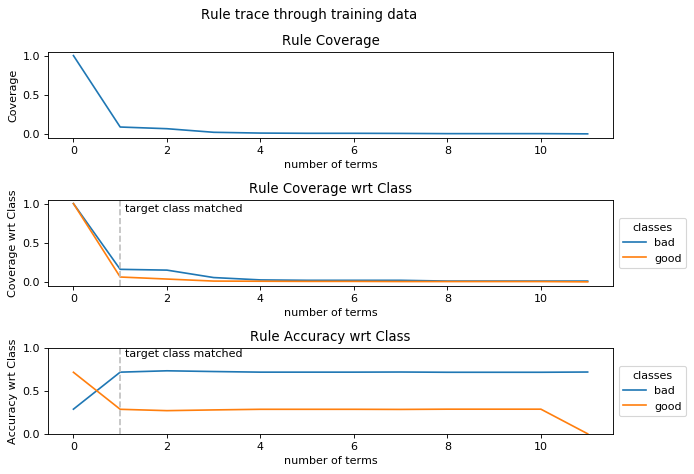

In [12]:
# training data - could be a representative sample if original tr is too large or unavailable
training_data = X_train
training_labels = y_train

# MAJORITY
# generate a set of paths, sorting can be tuned
sorted_fp = get_sorted_fp(discretize_paths(get_paths(nfp, instance, by_tree = False
                                         , which_trees='majority')
                                           , vars_dict, 4, equal_counts=True),
                                 support = 0.025, alpha = 0.0)
# create the rule accumulator
ra = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp)

# run the profile
ra, model_votes = profile_instance(instance=instance, target_class=0
                                     , fp_object = nfp
                                     , rule_acc = ra
                                     , training_data = encoder.transform(training_data)
                                     , training_labels = training_labels
                                     , features = onehot_features
                                     , class_names = class_names
                                     , stopping_param = 1)

# MINORITY
# generate a set of paths, sorting can be tuned
sorted_fp_min = get_sorted_fp(discretize_paths(get_paths(nfp, instance, by_tree = False
                                                         , which_trees='minority')
                                           , vars_dict, 4, equal_counts=True),
                                 support = 0.025, alpha = 0.4) 

# create the rule accumulator
ra_min = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp_min)

# run the profile
ra_min, model_votes = profile_instance(instance=instance, target_class=0
                                     , fp_object = nfp
                                     , rule_acc = ra_min
                                     , training_data = encoder.transform(training_data)
                                     , training_labels = training_labels
                                     , features = onehot_features
                                     , class_names = class_names
                                     , stopping_param = 1)

In [ ]:
pretty_print(ra.rule, onehot_dict)

In [13]:
ra.prune_rule()
pretty_print(ra.pruned_rule)

['crhis_A30 False',
 'crhis_A31 False',
 'job_A174 True',
 'tel_A192 True',
 'emp_A75 True',
 'pers_A93 True',
 'chk_A12 True']

In [14]:
p_count(training_labels.loc[apply_rule(ra.pruned_rule, encoder.transform(training_data), onehot_features)].values)

{'counts': array([1], dtype=int64),
 'labels': array([1], dtype=int64),
 'p_counts': array([1.])}

In [15]:
ra.pruned_rule

[('crhis_A30', True, 0.5),
 ('crhis_A31', True, 0.5),
 ('job_A174', False, 0.5),
 ('tel_A192', False, 0.5),
 ('emp_A75', False, 0.5),
 ('pers_A93', False, 0.5),
 ('chk_A12', False, 0.5)]

In [16]:
p_count(training_labels.loc[apply_rule([
 ('crhis_A30', True, 0.5),
 ('crhis_A31', True, 0.5),
 ('job_A174', False, 0.5),
 ('tel_A192', False, 0.5),
 ('emp_A75', False, 0.5),
 #('pers_A93', False, 0.5),
 ('chk_A12', False, 0.5)
], encoder.transform(training_data), onehot_features)].values)

{'counts': array([2, 1], dtype=int64),
 'labels': array([0, 1], dtype=int64),
 'p_counts': array([0.66666667, 0.33333333])}

In [17]:
ra4 = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp_min)
for i in range(4):
    ra4.add_rule()
ra4.prune_rule()
pretty_print(ra4.pruned_rule)

['job_A173 False',
 'chk_A11 False',
 'crhis_A31 False',
 'hous_A153 True',
 'chk_A14 False']

In [18]:
p_count(training_labels.loc[apply_rule(ra4.pruned_rule, encoder.transform(training_data), onehot_features)].values)

{'counts': array([5, 4], dtype=int64),
 'labels': array([0, 1], dtype=int64),
 'p_counts': array([0.55555556, 0.44444444])}

In [19]:
pretty_print(ra_min.rule)

['job_A173 False',
 'chk_A11 False',
 'crhis_A31 False',
 'hous_A153 True',
 'chk_A14 False',
 'hous_A151 False',
 'crhis_A30 False',
 'tel_A191 False',
 'plans_A141 False',
 'crhis_A34 False',
 'prop_A121 False',
 'pps_A42 False',
 'chk_A13 False',
 'job_A172 False',
 'chk_A12 True',
 'tel_A192 True',
 'pers_A91 False',
 'svng_A62 False']

In [20]:
ra_min.prune_rule()
pretty_print(ra_min.pruned_rule)

['job_A173 False',
 'crhis_A31 False',
 'hous_A153 True',
 'crhis_A30 False',
 'plans_A141 False',
 'crhis_A34 False',
 'prop_A121 False',
 'pps_A42 False',
 'job_A172 False',
 'chk_A12 True',
 'tel_A192 True',
 'pers_A91 False',
 'svng_A62 False']

In [21]:
p_count(training_labels.loc[apply_rule(ra_min.pruned_rule, encoder.transform(training_data), onehot_features)].values)

{'counts': array([1], dtype=int64),
 'labels': array([0], dtype=int64),
 'p_counts': array([1.])}

In [22]:
pretty_print(ra_min.tight_rule)

['hous_A153 True', 'chk_A12 True', 'tel_A192 True']

In [23]:
p_count(training_labels.loc[apply_rule(ra_min.tight_rule, encoder.transform(training_data), onehot_features)].values)

{'counts': array([7, 6], dtype=int64),
 'labels': array([0, 1], dtype=int64),
 'p_counts': array([0.53846154, 0.46153846])}

# Part 3. Other Demos

## treeinterpreter - local explanations from conditional probabilities

In [24]:
from treeinterpreter import treeinterpreter as ti, utils
prediction, bias, contributions = ti.predict(rf, encoder.transform(batch[instance:instance + 1]))

interp_cols = sum([['predictor'], class_names, ['abseff']], [])
interp = pd.DataFrame(columns=interp_cols)
# now extract contributions for each instance
for c, feature in zip(contributions[0], onehot_features):
    if any(c != 0):
        vals = c.tolist()
        vals.insert(0, feature)
        vals.append(sum(abs(c)))
        interp = interp.append(dict(zip(interp_cols, vals))
                               , ignore_index=True)

In [25]:
interp = interp.sort_values('abseff', ascending=False).reset_index().drop('index', axis=1)
interp

,predictor,bad,good,abseff
0,chk_A14,0.062797,-0.062797,0.125594
1,prop_A124,0.046222,-0.046222,0.092444
2,chk_A11,-0.044415,0.044415,0.088830
3,hous_A152,0.038430,-0.038430,0.076860
4,chk_A12,0.037675,-0.037675,0.075350
5,crhis_A34,0.029607,-0.029607,0.059213
6,hous_A153,0.025427,-0.025427,0.050853
7,pers_A93,-0.021552,0.021552,0.043104
8,pers_A92,-0.017124,0.017124,0.034247
9,pps_A40,0.017075,-0.017075,0.034149


In [26]:
interp = interp.sort_values('bad', ascending=False).reset_index().drop('index', axis=1)
interp

,predictor,bad,good,abseff
0,chk_A14,0.062797,-0.062797,0.125594
1,prop_A124,0.046222,-0.046222,0.092444
2,hous_A152,0.038430,-0.038430,0.076860
3,chk_A12,0.037675,-0.037675,0.075350
4,crhis_A34,0.029607,-0.029607,0.059213
5,hous_A153,0.025427,-0.025427,0.050853
6,pps_A40,0.017075,-0.017075,0.034149
7,emp_A71,0.016832,-0.016832,0.033663
8,emp_A75,0.016410,-0.016410,0.032820
9,svng_A61,0.012191,-0.012191,0.024381


In [27]:
priors = dict(zip(interp_cols[1:],  np.append(bias[0], 1.0)))
priors['predictor'] = 'priors (bias)'
totals = dict(zip(interp_cols[1:],  interp.sum()[1:].values))
totals['predictor'] = 'Total'
preds = dict(zip(interp_cols[1:],  np.append(prediction, 1.0)))
preds['predictor'] = 'P(class)'
interp_totals = pd.DataFrame(columns=interp_cols)
interp_totals = interp_totals.append(priors, ignore_index=True)

interp_totals = interp_totals.append(totals, ignore_index=True)
interp_totals = interp_totals.append(preds, ignore_index=True)
interp_totals

,predictor,bad,good,abseff
0,priors (bias),0.286240,0.713760,1.000000
1,Total,0.198595,-0.198595,1.186652
2,P(class),0.484835,0.515165,1.000000


## LIME

In [28]:
# basic setup
import lime
import lime.lime_tabular as limtab

np.random.seed(seed)

explainer = limtab.LimeTabularExplainer(training_data=np.array(X_train_enc.todense())
                                        , feature_names=onehot_features
                                        , training_labels=y_train
                                        , class_names=class_names
                                        , categorical_features=range(len(onehot_features))
                                        , categorical_names=onehot_features
                                        , mode='classification'
                                        , discretize_continuous=False
                                        , verbose=False)

exp = explainer.explain_instance(np.array(encoder.transform(batch[instance:instance+1]).todense())[0]
                                 , rf.predict_proba
                                 , top_labels=4)

[('chk_A14=0', -0.13334228604117992),
 ('chk_A11=0', 0.11983596920539495),
 ('crhis_A30=0', 0.09678908731356821),
 ('crhis_A31=0', 0.09279887019815443),
 ('pps_A41=0', -0.053125686338286425),
 ('crhis_A34=0', -0.052328018618106334),
 ('debt_A102=0', 0.047639173476681416),
 ('emp_A72=0', 0.047131868528410184),
 ('plans_A143=1', 0.04509749913095561),
 ('plans_A142=0', 0.03899391500106701)]

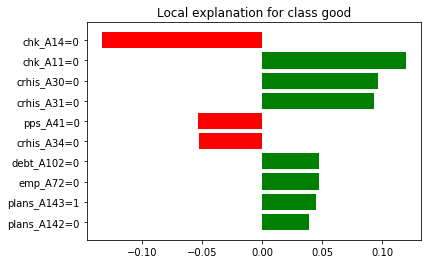

In [29]:
fig = exp.as_pyplot_figure(label=pred_class_code)

exp.as_list(label=pred_class_code)

[('chk_A14=0', 0.13334228604117987),
 ('chk_A11=0', -0.11983596920539495),
 ('crhis_A30=0', -0.09678908731356826),
 ('crhis_A31=0', -0.09279887019815443),
 ('pps_A41=0', 0.053125686338286425),
 ('crhis_A34=0', 0.05232801861810629),
 ('debt_A102=0', -0.047639173476681444),
 ('emp_A72=0', -0.04713186852841017),
 ('plans_A143=1', -0.04509749913095563),
 ('plans_A142=0', -0.03899391500106697)]

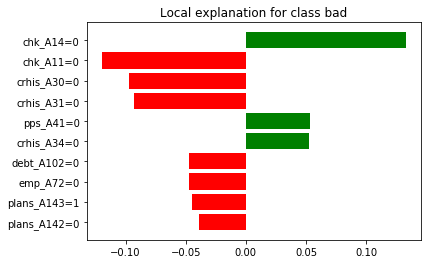

In [30]:
# Show the runner up class details
fig = exp.as_pyplot_figure(label=second_class_code)
exp.as_list(label=second_class_code)

In [31]:
exp.show_in_notebook()

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime
import julian
jul_conv = lambda x : 0 if x[0] == 'nan' or x[1] == 'nan' else julian.to_jd(datetime.strptime(x[0] + ' ' + x[1], '%d/%m/%Y %M:%S'))

# helper function for data frame str / summary
def rstr(df):
    return df.shape, df.apply(lambda x: [x.unique()])

# random seed for train test split and sampling
random_state = 123

vtypes = {'Accident_Index' : object, 'Location_Easting_OSGR' : np.float64, 'Location_Northing_OSGR' : np.float64,
       'Longitude' : np.float64, 'Latitude' : np.float64, 'Police_Force' : np.uint8, 'Accident_Severity' : np.uint8,
       'Number_of_Vehicles' : np.uint8, 'Number_of_Casualties' : np.uint8, 'Date' : object, 'Day_of_Week' : np.uint8,
       'Time' : object, 'Local_Authority_(District)' : np.uint16, 'Local_Authority_(Highway)' : object,
       '1st_Road_Class' : np.uint8, '1st_Road_Number' : np.uint16, 'Road_Type' : np.uint8, 'Speed_limit' : np.float16,
       'Junction_Detail' : np.uint8, 'Junction_Control' : np.uint8, '2nd_Road_Class' : np.uint8,
       '2nd_Road_Number' : np.uint16, 'Pedestrian_Crossing-Human_Control' : np.uint8,
       'Pedestrian_Crossing-Physical_Facilities' : np.uint8, 'Light_Conditions' : np.uint8,
       'Weather_Conditions' : np.uint8, 'Road_Surface_Conditions' : np.uint8,
       'Special_Conditions_at_Site' : np.uint8, 'Carriageway_Hazards' : np.uint8,
       'Urban_or_Rural_Area' : np.uint8, 'Did_Police_Officer_Attend_Scene_of_Accident' : np.uint8,
       'LSOA_of_Accident_Location' : object}

accident = pd.read_csv('data_source_files\\Accidents.csv', dtype=vtypes, low_memory=False)

# convert date and time to julian
accident['Date_j'] = pd.Series([(str(d), str(t)) for d, t in zip(accident['Date'], accident['Time'])]).map(jul_conv)
# tidy where necessary
accident['Local_Authority_(Highway)'] = accident['Local_Authority_(Highway)'].str.slice(stop=3)
# and drop unecessary/noisy columns
accident.drop(labels=['Date', 'Time', 'Accident_Index', 'LSOA_of_Accident_Location'], axis=1, inplace=True)

# get rid of na
accident = accident.fillna(0.0)

# rearrange so class col at end
class_col = 'Accident_Severity'
pos = np.where(accident.columns == class_col)[0][0]
var_names = list(accident.columns[:pos]) + list(accident.columns[pos + 1:]) + list(accident.columns[pos:pos + 1])
accident = accident[var_names]

# save
accident.to_csv('forest_surveyor\\datafiles\\accident.csv.gz', index=False, compression='gzip')

# create small set that is easier to play with on a laptop
samp = accident.sample(frac=0.1, random_state=random_state).reset_index()
samp.drop(labels='index', axis=1, inplace=True)
samp.to_csv('forest_surveyor\\datafiles\\accident_samp.csv.gz', index=False, compression='gzip')

samp = accident.sample(frac=0.01, random_state=random_state).reset_index()
samp.drop(labels='index', axis=1, inplace=True)
samp.to_csv('forest_surveyor\\datafiles\\accident_small_samp.csv.gz', index=False, compression='gzip')

In [15]:
rstr(accident)

((136621, 29),
 Location_Easting_OSGR                          [[519310.0, 551920.0, 505930.0, 527770.0, 5107...
 Location_Northing_OSGR                         [[188730.0, 174560.0, 183850.0, 168930.0, 1772...
 Longitude                                      [[-0.279323, 0.184928, -0.473837, -0.164442, -...
 Latitude                                       [[51.584754, 51.449595, 51.543563, 51.404958, ...
 Police_Force                                   [[1, 48, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 16...
 Number_of_Vehicles                             [[2, 1, 3, 4, 5, 8, 6, 7, 9, 11, 10, 16, 12, 13]]
 Number_of_Casualties                           [[1, 2, 3, 4, 5, 12, 10, 7, 6, 16, 19, 8, 11, ...
 Day_of_Week                                                              [[3, 4, 5, 6, 7, 1, 2]]
 Local_Authority_(District)                     [[28, 18, 26, 22, 25, 20, 1, 30, 12, 6, 31, 5,...
 Local_Authority_(Highway)                                  [[E09, EHE, E10, E06, E08, W06, S12]]
 1st_

In [5]:
import sys
import math
import numpy as np
from forest_surveyor import p_count
from pandas import DataFrame, Series
from pyfpgrowth import find_frequent_patterns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import deque, defaultdict
from scipy.stats import sem, entropy
from operator import itemgetter
from itertools import chain
from copy import deepcopy


from forest_surveyor.datasets import bankmark_data
mydata = bankmark_data()
self = mydata

self.data = accident
self.data_pre = pd.DataFrame.copy(accident)
self.class_col = 'Accident_Severity'
self.pickle_dir = 'accident_pickles'
self.var_names =list(self.data.columns)
self.var_types = ['nominal' if dt.name == 'object' else 'continuous' for dt in self.data.dtypes.values]
self.features = [vn for vn in self.var_names if vn != self.class_col]
self.class_names = list(self.data[self.class_col].unique())

self.le_dict = {}
self.var_dict = {}
self.onehot_dict = {}

for v, t in zip(self.var_names, self.var_types):
    if t == 'nominal':
        # create a label encoder for all categoricals
        self.le_dict[v] = LabelEncoder().fit(self.data[v].unique())
        # create a dictionary of categorical names
        names = list(self.le_dict[v].classes_)
        # transform each categorical column
        self.data_pre[v] = self.le_dict[v].transform(self.data[v])
        # create the reverse lookup
        for n in names:
            self.onehot_dict[v + '_' + str(n)] = v
    else:
        self.data_pre[v] = self.data[v]

    self.var_dict[v] = {'labels' : names if t == 'nominal' else None
                        , 'onehot_labels' : [v + '_' + str(n) for n in names] if t == 'nominal' else None
                        , 'class_col' : True if v == class_col else False
                        , 'data_type' : t}

if any(n == 'nominal' for n in self.var_types ): del names
del t

self.categorical_features=[i for i, (c, t) in enumerate(zip([self.var_dict[f]['class_col'] for f in self.features],
[self.var_dict[f]['data_type'] == 'nominal' for f in self.features])) if not c and t]

# creates a flat list just for the features
self.onehot_features = []
self.continuous_features = []
for f, t in zip(self.var_names, self.var_types):
    if f == self.class_col: continue
    if t == 'continuous':
        self.continuous_features.append(f)
    else:
        self.onehot_features.append(self.var_dict[f]['onehot_labels'])

# They get stuck on the end by encoding
self.onehot_features.append(self.continuous_features)
# flatten out the nesting
self.onehot_features = list(chain.from_iterable(self.onehot_features))



In [6]:
if len(self.categorical_features) > 0:
    encoder = OneHotEncoder(categorical_features=self.categorical_features)
    encoder.fit(self.data_pre[self.data_pre.columns[4:]].as_matrix())
    self.encoder = encoder
else:
    self.encoder = None

In [86]:
[(c, np.isfinite(accident[c]).all()) for c in accident.columns[0:9]]


[('Location_Easting_OSGR', False),
 ('Location_Northing_OSGR', False),
 ('Longitude', False),
 ('Latitude', False),
 ('Police_Force', True),
 ('Number_of_Vehicles', True),
 ('Number_of_Casualties', True),
 ('Day_of_Week', True),
 ('Local_Authority_(District)', True)]

In [87]:
[(c, np.isfinite(accident[c]).all()) for c in accident.columns[10:]]

[('1st_Road_Class', True),
 ('1st_Road_Number', True),
 ('Road_Type', True),
 ('Speed_limit', True),
 ('Junction_Detail', True),
 ('Junction_Control', True),
 ('2nd_Road_Class', True),
 ('2nd_Road_Number', True),
 ('Pedestrian_Crossing-Human_Control', True),
 ('Pedestrian_Crossing-Physical_Facilities', True),
 ('Light_Conditions', True),
 ('Weather_Conditions', True),
 ('Road_Surface_Conditions', True),
 ('Special_Conditions_at_Site', True),
 ('Carriageway_Hazards', True),
 ('Urban_or_Rural_Area', True),
 ('Did_Police_Officer_Attend_Scene_of_Accident', True),
 ('Date_j', True),
 ('Accident_Severity', True)]

In [9]:
list(np.where(np.isfinite(accident.Longitude) == False)[0])

[62592, 62618, 83330, 129439, 132298, 132431, 132527]

In [11]:
accident.iloc[list(np.where(np.isfinite(accident.Longitude) == False)[0]), :]

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),Local_Authority_(Highway),...,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Date_j,Accident_Severity
62592,NaN,NaN,NaN,NaN,21,2,1,2,255,E10,...,0,4,1,2,0,0,3,1,2.457700e+06,2
62618,NaN,NaN,NaN,NaN,21,1,1,5,257,E06,...,0,1,2,2,0,0,3,1,2.457703e+06,3
83330,NaN,NaN,NaN,NaN,40,3,3,2,420,E06,...,0,1,1,1,0,0,3,1,2.457721e+06,3
129439,NaN,NaN,NaN,NaN,93,1,1,1,934,S12,...,0,1,1,1,0,0,3,1,2.457503e+06,3
132298,NaN,NaN,NaN,NaN,96,2,3,6,939,S12,...,255,255,255,255,0,255,3,2,2.457494e+06,3
132431,NaN,NaN,NaN,NaN,96,2,1,4,939,S12,...,0,1,2,2,0,0,3,1,2.457604e+06,2
132527,NaN,NaN,NaN,NaN,96,1,1,2,939,S12,...,0,1,1,1,0,0,3,2,2.457658e+06,3


In [1]:
from forest_surveyor.datasets import accident_data

In [2]:
from forest_surveyor.datasets import accident_samp_data

In [3]:
from forest_surveyor.datasets import accident_small_samp_data

In [4]:
from forest_surveyor.datasets import adult_data

In [5]:
from forest_surveyor.datasets import adult_samp_data

In [6]:
from forest_surveyor.datasets import adult_small_samp_data

In [4]:
from forest_surveyor.datasets import bankmark_data

In [5]:
from forest_surveyor.datasets import bankmark_samp_data

In [9]:
from forest_surveyor.datasets import car_data

In [6]:
from forest_surveyor.datasets import cardiotography_data

In [11]:
from forest_surveyor.datasets import credit_data

In [12]:
from forest_surveyor.datasets import german_data

In [13]:
from forest_surveyor.datasets import nursery_data

In [14]:
from forest_surveyor.datasets import nursery_samp_data

In [15]:
from forest_surveyor.datasets import lending_data

In [16]:
from forest_surveyor.datasets import lending_samp_data

In [17]:
from forest_surveyor.datasets import lending_small_samp_data

In [18]:
from forest_surveyor.datasets import lending_tiny_samp_data

In [19]:
from forest_surveyor.datasets import rcdv_data

In [20]:
from forest_surveyor.datasets import rcdv_samp_data

In [3]:
mydata = accident_data()
(mydata.data.shape, mydata.data.shape[0] * mydata.data.shape[1], mydata.data.shape[0] * (len(mydata.onehot_features) + 1))

((136621, 29), 3962009, 4781735)

In [15]:
mydata.data.dtypes

Location_Easting_OSGR                          float64
Location_Northing_OSGR                         float64
Longitude                                      float64
Latitude                                       float64
Police_Force                                     int64
Number_of_Vehicles                               int64
Number_of_Casualties                             int64
Day_of_Week                                      int64
Local_Authority_(District)                       int64
Local_Authority_(Highway)                       object
1st_Road_Class                                   int64
1st_Road_Number                                  int64
Road_Type                                      float64
Speed_limit                                    float64
Junction_Detail                                float64
Junction_Control                               float64
2nd_Road_Class                                 float64
2nd_Road_Number                                float64
Pedestrian

In [13]:
len(mydata.onehot_features) + 1

AttributeError: 'data_container' object has no attribute 'onehot_features'

In [161]:
# mydata = rcdv_data()
dataset = 'lending_tiny'
# create a small set that is easier to play with on a laptop

samp = mydata.data.sample(frac=0.0025, random_state=mydata.random_state).reset_index()
samp.drop(labels='index', axis=1, inplace=True)

samp.to_csv('forest_surveyor\\datafiles\\' + dataset + '_samp.csv.gz', index=False, compression='gzip')

In [28]:
def in_ipynb():
    try:
        cfg = get_ipython().config
        if len(cfg.keys()) > 0:
            if list(cfg.keys())[0]  == 'IPKernelApp':
                return(True)
            else:
                return(False)
        else:
            return(False)
    except NameError:
        return(False)

In [29]:
in_ipynb()

True

In [24]:
cfg = get_ipython().config

In [27]:
len(cfg.keys())

1

In [17]:
import numpy as np
import pandas as pd
random_state = 123
bankmark = pd.read_csv('data_source_files\\bank-additional-full.csv', sep=';', low_memory=False)

dt = [str(t).replace('64', '16') if str(t) != 'object' else str(t) for t in bankmark.dtypes.values]
nm = [c for c in bankmark.columns]
vtypes = {n : np.dtype(d) for d, n in zip(dt, nm)}

# import again with good vartypes
bankmark = pd.read_csv('data_source_files\\bank-additional-full.csv', sep=';', dtype=var_types, low_memory=False)
bankmark.day_of_week = bankmark.day_of_week.replace({'mon': 0, 'tue': 1, 'wed': 2, 'thu': 3, 'fri': 4})
bankmark.month = bankmark.month.replace({'jan': 0, 'feb': 1, 'mar': 2, 'apr': 3, 'may': 4, 'jun': 5, 'jul': 6, 'aug': 7, 'sep': 8, 'oct': 9, 'nov': 10, 'dec': 11})

# save
bankmark.to_csv('forest_surveyor\\datafiles\\bankmark.csv.gz', index=False, compression='gzip')

# create small set that is easier to play with on a laptop
samp = bankmark.sample(frac=0.05, random_state=random_state).reset_index()
samp.drop(labels='index', axis=1, inplace=True)
samp.to_csv('forest_surveyor\\datafiles\\bankmark_samp.csv.gz', index=False, compression='gzip')

In [19]:
vtypes

{'age': dtype('int16'),
 'campaign': dtype('int16'),
 'cons.conf.idx': dtype('float16'),
 'cons.price.idx': dtype('float16'),
 'contact': dtype('O'),
 'day_of_week': dtype('O'),
 'default': dtype('O'),
 'duration': dtype('int16'),
 'education': dtype('O'),
 'emp.var.rate': dtype('float16'),
 'euribor3m': dtype('float16'),
 'housing': dtype('O'),
 'job': dtype('O'),
 'loan': dtype('O'),
 'marital': dtype('O'),
 'month': dtype('O'),
 'nr.employed': dtype('float16'),
 'pdays': dtype('int16'),
 'poutcome': dtype('O'),
 'previous': dtype('int16'),
 'y': dtype('O')}

In [15]:
# helper function for data frame str / summary
def rstr(df):
    return df.shape, df.apply(lambda x: [x.unique()])

rstr(bankmark)

((41188, 21),
 age               [[56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, ...
 job               [[housemaid, services, admin., blue-collar, te...
 marital                      [[married, single, divorced, unknown]]
 education         [[basic.4y, high.school, basic.6y, basic.9y, p...
 default                                        [[no, unknown, yes]]
 housing                                        [[no, yes, unknown]]
 loan                                           [[no, yes, unknown]]
 contact                                     [[telephone, cellular]]
 month                            [[4, 5, 6, 7, 9, 10, 11, 2, 3, 8]]
 day_of_week                                       [[0, 1, 2, 3, 4]]
 duration          [[261, 149, 226, 151, 307, 198, 139, 217, 380,...
 campaign          [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...
 pdays             [[nan, 6.0, 4.0, 3.0, 5.0, 1.0, 0.0, 10.0, 7.0...
 previous                                 [[0, 1, 2, 3, 4, 5, 6, 7]]
 poutcome           

In [88]:
mydata = bankmark_data()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [90]:
bankmark.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month               int64
day_of_week         int64
duration            int64
campaign            int64
pdays             float16
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [91]:
bankmark.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,4,0,...,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,4,0,...,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,4,0,...,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,4,0,...,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,4,0,...,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [92]:
var_types =['nominal' if dt == 'object' else 'continuous' for dt in bankmark.dtypes.values]


['continuous',
 'nominal',
 'nominal',
 'nominal',
 'nominal',
 'nominal',
 'nominal',
 'nominal',
 'continuous',
 'continuous',
 'continuous',
 'continuous',
 'continuous',
 'continuous',
 'nominal',
 'continuous',
 'continuous',
 'continuous',
 'continuous',
 'continuous',
 'nominal']